In [60]:
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
num_train = 10000# 1000000
num_test= 2000
SNR = 10

# assume we know the channel_length
channel_length = 2
num_preambles = 1
preamble_length = 100
recieved_length = preamble_length + channel_length - 1

preambles = np.random.randint(0,2,(num_preambles,preamble_length)) 

def add_awgn_noise(signal,SNR_dB):
    """  Adds AWGN noise vector to signal 
         to generate a resulting signal vector y of specified SNR in dB
    """
    L=len(signal)
    SNR = 10**(SNR_dB/10.0) #SNR to linear scale
    Esym=np.sum(np.square(np.abs(signal)))/L #Calculate actual symbol energy
    N0=Esym/SNR; #Find the noise spectral density
    if(isinstance(signal[0], complex)):
        noiseSigma=np.sqrt(N0/2.0)#Standard deviation for AWGN Noise when x is complex
        n = noiseSigma*(np.random.randn(1,L)+1j*np.random.randn(1,L))#computed noise 
    else:
        noiseSigma = np.sqrt(N0);#Standard deviation for AWGN Noise when x is real
        n = noiseSigma*np.random.randn(1,L)#computed noise
    y = signal + n #received signal
    
    return y.flatten()

channel_train = np.zeros((num_train,channel_length))
preamble_train = np.zeros((num_train*num_preambles, preamble_length*2))

channel_test = np.zeros((num_test,channel_length))
preamble_test = np.zeros((num_test*num_preambles, preamble_length*2))

for i in range(0, num_train):
    channel_train[i,:]=np.random.uniform(0.2,1,channel_length)
    # if the total power is greater than 1, then normalize
    if sum(channel_train[i])>=1:
        channel_train[i] = channel_train[i]/(sum(channel_train[i]))
        
    for k in range(num_preambles):
        preamble_conv = add_awgn_noise(sig.convolve(preambles[k], channel_train[i], mode='same'), SNR)
        preamble_total = np.hstack((preambles[k], preamble_conv))
        preamble_train[i+k,:] = preamble_total
        
        
for i in range(0, num_test):
    channel_test[i,:]=np.random.uniform(0.2,1,channel_length)
    # if the total power is greater than 1, then normalize
    if sum(channel_test[i])>=1:
        channel_test[i] = channel_test[i]/(sum(channel_test[i]))
        
    for k in range(num_preambles):
        preamble_conv = add_awgn_noise(sig.convolve(preambles[k], channel_test[i], mode='same'), SNR)
        preamble_total = np.hstack((preambles[k], preamble_conv))
        preamble_test[i+k,:] = preamble_total
print(preamble_train.shape)
print(channel_train.shape)
print(preamble_test.shape)
print(channel_test.shape)

(10000, 200)
(10000, 2)
(2000, 200)
(2000, 2)


In [67]:
def create_model(input_layer_dim, hidden_layer_dim, input_dim, output_dim):
    model = Sequential()
    model.add(Dense(input_layer_dim, input_dim=input_dim, activation='relu'))
    model.add(Dense(hidden_layer_dim, activation='relu'))
    model.add(Dense(output_dim, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

In [68]:
model = create_model(300, 300, preamble_train.shape[1], channel_train.shape[1])
model.fit(preamble_train, channel_train, epochs=100)
predictions = model.predict(preamble_test)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mse = mean_squared_error(predictions, channel_test)
mabse = mean_absolute_error(predictions, channel_test)
print('Mean Squared Error: {0}'.format(mse))
print('Mean Absolute Error: {0}'.format(mabse))

Epoch 1/100
10000/10000 [==============================] - 1s - loss: 0.0021 - mean_absolute_error: 0.0331     
Epoch 2/100
10000/10000 [==============================] - 0s - loss: 0.0011 - mean_absolute_error: 0.0263     
Epoch 3/100
10000/10000 [==============================] - 0s - loss: 0.0010 - mean_absolute_error: 0.0256     
Epoch 4/100
10000/10000 [==============================] - 0s - loss: 0.0010 - mean_absolute_error: 0.0256     
Epoch 5/100
10000/10000 [==============================] - 0s - loss: 9.7259e-04 - mean_absolute_error: 0.0247     
Epoch 6/100
10000/10000 [==============================] - 0s - loss: 9.8697e-04 - mean_absolute_error: 0.0249     
Epoch 7/100
10000/10000 [==============================] - 0s - loss: 9.6080e-04 - mean_absolute_error: 0.0245     
Epoch 8/100
10000/10000 [==============================] - 0s - loss: 9.2411e-04 - mean_absolute_error: 0.0241     
Epoch 9/100
10000/10000 [==============================] - 0s - loss: 9.4369e-04 - mean_

10000/10000 [==============================] - 0s - loss: 7.3379e-04 - mean_absolute_error: 0.0214     
Epoch 72/100
10000/10000 [==============================] - 0s - loss: 7.2669e-04 - mean_absolute_error: 0.0214     
Epoch 73/100
10000/10000 [==============================] - 1s - loss: 7.3329e-04 - mean_absolute_error: 0.0215     
Epoch 74/100
10000/10000 [==============================] - 1s - loss: 7.2887e-04 - mean_absolute_error: 0.0214     
Epoch 75/100
10000/10000 [==============================] - 1s - loss: 7.2709e-04 - mean_absolute_error: 0.0214     
Epoch 76/100
10000/10000 [==============================] - 1s - loss: 7.1698e-04 - mean_absolute_error: 0.0212     
Epoch 77/100
10000/10000 [==============================] - 1s - loss: 7.3385e-04 - mean_absolute_error: 0.0215     
Epoch 78/100
10000/10000 [==============================] - 1s - loss: 7.0759e-04 - mean_absolute_error: 0.0211     
Epoch 79/100
10000/10000 [==============================] - 1s - loss: 7.3504

In [69]:
print(predictions)
print(channel_test)

[[0.48779678 0.51681054]
 [0.34164235 0.6559167 ]
 [0.3179882  0.6839584 ]
 ...
 [0.24181327 0.7570231 ]
 [0.557716   0.44316363]
 [0.21840838 0.7654285 ]]
[[0.51842791 0.48157209]
 [0.30612579 0.69387421]
 [0.27710062 0.72289938]
 ...
 [0.29088773 0.70911227]
 [0.54597648 0.45402352]
 [0.26190762 0.73809238]]


In [127]:
def generate_topleitz(row_vector):
    first_row = row_vector[:2]
    first_col = row_vector
    from scipy import linalg as la
    return la.toeplitz(first_col, first_row)

def least_squares(A, b):
    return np.linalg.lstsq(A, b)[0]

def perform_least_squares(dataset, preamble_length):
    predictions = []
    for i in range(dataset.shape[0]):
        A, b = generate_topleitz(dataset[i][:preamble_length]), dataset[i][preamble_length:]
#         print(A.shape, b.shape)
        prediction = least_squares(A, b)
        predictions.append(prediction)
    return np.array(predictions)


predictions_least_squares = perform_least_squares(preamble_test)
mse = mean_squared_error(predictions_least_squares, channel_test)
mabse = mean_absolute_error(predictions_least_squares, channel_test)
print(predictions_least_squares)
print(channel_test)
print('Mean Squared Error: {0}'.format(mse))
print('Mean Absolute Error: {0}'.format(mabse))

TypeError: perform_least_squares() missing 1 required positional argument: 'preamble_length'

In [147]:
num_train = 100000# 1000000
num_test= 20000
channel_train_varying = np.zeros((num_train,channel_length))
preamble_train_varying = np.zeros((num_train, preamble_length*2))

channel_test_varying = np.zeros((num_test,channel_length))
preamble_test_varying = np.zeros((num_test, preamble_length*2))

print(channel_train_varying.shape)
print(preamble_train_varying.shape)

print(channel_test_varying.shape)
print(preamble_test_varying.shape)

random_preambles_train = np.random.randint(0,2,(num_train,preamble_length)) 
random_preables_test = np.random.randint(0,2,(num_test,preamble_length)) 

for i in range(0, num_train):
    channel_train_varying[i,:]=np.random.uniform(0.2,1,channel_length)
    # if the total power is greater than 1, then normalize
    if sum(channel_train_varying[i])>=1:
        channel_train_varying[i] = channel_train_varying[i]/(sum(channel_train_varying[i]))
        
    
    preamble_conv = add_awgn_noise(sig.convolve(random_preambles_train[i], channel_train_varying[i], mode='same'), SNR)
    preamble_total = np.hstack((random_preambles_train[i], preamble_conv))
    preamble_train_varying[i,:] = preamble_total

        
for i in range(0, num_test):
    channel_test_varying[i,:]=np.random.uniform(0.2,1,channel_length)
    # if the total power is greater than 1, then normalize
    if sum(channel_test_varying[i])>=1:
        channel_test_varying[i] = channel_test_varying[i]/(sum(channel_test_varying[i]))
        
   
    preamble_conv = add_awgn_noise(sig.convolve(random_preables_test[i], channel_test_varying[i], mode='same'), SNR)
    preamble_total = np.hstack((random_preables_test[i], preamble_conv))
    preamble_test_varying[i,:] = preamble_total
    


(100000, 2)
(100000, 60)
(20000, 2)
(20000, 60)


In [148]:
model = create_model(300, 300, preamble_train_varying.shape[1], channel_train_varying.shape[1])
model.fit(preamble_train_varying, channel_train_varying, epochs=100)
predictions = model.predict(preamble_test_varying)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(predictions, channel_test_varying)
mabse = mean_absolute_error(predictions, channel_test_varying)
print('Mean Squared Error: {0}'.format(mse))
print('Mean Absolute Error: {0}'.format(mabse))

Epoch 1/100
100000/100000 [==============================] - 19s - loss: 0.0056 - mean_absolute_error: 0.0575    
Epoch 2/100
100000/100000 [==============================] - 16s - loss: 0.0035 - mean_absolute_error: 0.0469    
Epoch 3/100
100000/100000 [==============================] - 16s - loss: 0.0032 - mean_absolute_error: 0.0449    
Epoch 4/100
100000/100000 [==============================] - 17s - loss: 0.0031 - mean_absolute_error: 0.0438    
Epoch 5/100
100000/100000 [==============================] - 17s - loss: 0.0029 - mean_absolute_error: 0.0428    
Epoch 6/100
100000/100000 [==============================] - 16s - loss: 0.0028 - mean_absolute_error: 0.0419    
Epoch 7/100
100000/100000 [==============================] - 16s - loss: 0.0027 - mean_absolute_error: 0.0412    
Epoch 8/100
100000/100000 [==============================] - 16s - loss: 0.0026 - mean_absolute_error: 0.0405    
Epoch 9/100
100000/100000 [==============================] - 16s - loss: 0.0026 - mean_a

100000/100000 [==============================] - 16s - loss: 8.0152e-04 - mean_absolute_error: 0.0222    
Epoch 72/100
100000/100000 [==============================] - 17s - loss: 8.0007e-04 - mean_absolute_error: 0.0221    
Epoch 73/100
100000/100000 [==============================] - 17s - loss: 7.8997e-04 - mean_absolute_error: 0.0220    
Epoch 74/100
100000/100000 [==============================] - 16s - loss: 7.8656e-04 - mean_absolute_error: 0.0220    
Epoch 75/100
100000/100000 [==============================] - 16s - loss: 7.8123e-04 - mean_absolute_error: 0.0219    
Epoch 76/100
100000/100000 [==============================] - 17s - loss: 7.8275e-04 - mean_absolute_error: 0.0219    
Epoch 77/100
100000/100000 [==============================] - 17s - loss: 7.7464e-04 - mean_absolute_error: 0.0218    
Epoch 78/100
100000/100000 [==============================] - 16s - loss: 7.6757e-04 - mean_absolute_error: 0.0217    
Epoch 79/100
100000/100000 [==============================] -

In [149]:
predictions_least_squares_varying = perform_least_squares(preamble_test_varying, 30)
mse = mean_squared_error(predictions_least_squares_varying, channel_test_varying)
mabse = mean_absolute_error(predictions_least_squares_varying, channel_test_varying)
print(predictions_least_squares_varying)
print(channel_test_varying)
print('Mean Squared Error: {0}'.format(mse))
print('Mean Absolute Error: {0}'.format(mabse))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


[[0.38484195 0.51810586]
 [0.67968929 0.26289872]
 [0.56234035 0.479563  ]
 ...
 [0.60899069 0.36537104]
 [0.35076668 0.53384728]
 [0.26292495 0.66845198]]
[[0.4270143  0.5729857 ]
 [0.66159342 0.33840658]
 [0.49702087 0.50297913]
 ...
 [0.56383453 0.43616547]
 [0.45866739 0.54133261]
 [0.25005153 0.63090582]]
Mean Squared Error: 0.0035393469606816936
Mean Absolute Error: 0.04674040784826056


In [152]:
def generate_data_sets(range_size, preamble_length):
    datasets = []
    for train_size in range_size:
#         channel_train_varying = np.zeros((num_train,channel_length))
#         preamble_train_varying = np.zeros((num_train, preamble_length*2))
        preambles = np.random.randint(0, 2, (train_size, preamble_length))
        channel_train = []
        convolved_preambles = []
        for i in range(train_size):
            channel = np.random.uniform(0.2,1,channel_length)
            if sum(channel)>=1:
                channel = channel / sum(channel)
            preamble_conv = add_awgn_noise(sig.convolve(preambles[i], channel, mode='same'), SNR)
            convolved_preambles.append(preamble_conv)
            channel_train.append(channel)
        
        preamble_train = np.hstack([preambles, np.array(convolved_preambles)])
        channel_train = np.array(channel_train)
        datasets.append([preamble_train, channel_train])

    return datasets
# preamble_length = 20
# datasets = generate_data_sets(range(1000, 11000, 1000), 20)
# print(len(datasets))

In [156]:
from sklearn.model_selection import train_test_split
results_mse = {}
results_rmse = {}
results_mabse = {}
results_lstsq_mse = {}
results_lstsq_rmse = {}
results_lstsq_mabse = {}
xrange = range(1000, 11000, 1000)
for x in range(1000, 11000, 1000):
    results_mse[x] = []
    results_rmse[x] = []
    results_mabse[x] = []
    results_lstsq_mse[x] = []
    results_lstsq_mabse[x] = []
    results_lstsq_rmse[x] = []
for trial in range(10):
    print('Trial: {0}'.format(trial))
    nn_rmses = []
    nn_mses = []
    nn_mabses = []

    lstsq_rmses = []
    lstsq_mses = []
    lstsq_mabses = []
    preamble_length = 20
    datasets = generate_data_sets(range(1000, 11000, 1000), preamble_length)
    for i, num_train in zip(range(len(datasets)), xrange):
        print(i)
        dataset = datasets[i]
        preamble_train, preamble_test, channel_train, channel_test = train_test_split(dataset[0], dataset[1], test_size=0.2)
        print(preamble_train.shape, channel_train.shape, preamble_test.shape, channel_test.shape)
        model = create_model(300, 300, preamble_train.shape[1], channel_train.shape[1])
        model.fit(preamble_train, channel_train, verbose=0)
        predictions = model.predict(preamble_test)
        nn_mse = mean_squared_error(predictions, channel_test)
        nn_rmse = np.sqrt(nn_mse)
        nn_mabse = mean_absolute_error(predictions, channel_test)
        nn_mses.append(nn_mse)
        nn_rmses.append(nn_rmse)
        nn_mabses.append(nn_mabse)

        predictions_least_squares = perform_least_squares(preamble_test, preamble_length)
        lstsq_mse = mean_squared_error(predictions_least_squares, channel_test)
        lstsq_rmse = np.sqrt(lstsq_mse)
        lstsq_mabse = mean_absolute_error(predictions_least_squares, channel_test)
        
        results_mse[num_train].append(nn_mse)
        results_mabse[num_train].append(nn_mabse)
        results_rmse[num_train].append(nn_rmse)
        
        results_lstsq_mse[num_train].append(lstsq_mse)
        results_lstsq_rmse[num_train].append(lstsq_rmse)
        results_lstsq_mabse[num_train].append(lstsq_mabse)
        
        lstsq_mses.append(lstsq_mse)
        lstsq_rmses.append(lstsq_rmse)
        lstsq_mabses.append(lstsq_mabse)

    print(nn_mabses)
    print(lstsq_mabses)

print(results_mabse)
print(results_lstsq_mabse)

Trial: 0
0
(800, 40) (800, 2) (200, 40) (200, 2)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


1
(1600, 40) (1600, 2) (400, 40) (400, 2)
2
(2400, 40) (2400, 2) (600, 40) (600, 2)
3
(3200, 40) (3200, 2) (800, 40) (800, 2)
4
(4000, 40) (4000, 2) (1000, 40) (1000, 2)
5
(4800, 40) (4800, 2) (1200, 40) (1200, 2)
6
(5600, 40) (5600, 2) (1400, 40) (1400, 2)
7
(6400, 40) (6400, 2) (1600, 40) (1600, 2)
8
(7200, 40) (7200, 2) (1800, 40) (1800, 2)
9
(8000, 40) (8000, 2) (2000, 40) (2000, 2)
[0.08406030920122248, 0.06676998764669966, 0.06443736579408907, 0.060682087223940764, 0.05886281989875014, 0.06273412278897807, 0.056952138289969936, 0.05811538542946067, 0.057351577459247474, 0.054133999491254414]
[0.06002225182382049, 0.054954447437936524, 0.060021909426579576, 0.05849959464581744, 0.05874141777322911, 0.05831029410339937, 0.059308864877203646, 0.05947102065363795, 0.05932018619380837, 0.05743098961445617]
Trial: 1
0
(800, 40) (800, 2) (200, 40) (200, 2)
1
(1600, 40) (1600, 2) (400, 40) (400, 2)
2
(2400, 40) (2400, 2) (600, 40) (600, 2)
3
(3200, 40) (3200, 2) (800, 40) (800, 2)
4
(400

In [174]:
#k-nearest-neighbors sliding
def hammingDistance(a, b):
    return np.sum((a - b) ** 2)
def make_sliding_window_matrix_test(test_vector, window_length, training_set_size):
    new_vector = []
    for i in range(len(test_vector) - window_length + 1):
        new_vector.append(test_vector[i:i+window_length])
    vector = np.concatenate(new_vector)
    return np.tile(vector, (training_set_size, 1))

def make_training_set_sliding_window_matrix(X_train, window_length):
    new_matrix = []
    for i in range(X_train.shape[1] - window_length + 1):
        new_matrix.append(X_train[:, i:i+window_length])
    matrix = np.concatenate(new_matrix, axis=1)
    return matrix
def find_sliding_hamming_distances(sliding_window_matrix, X_train_sliding_window):
    added_matrices = (sliding_window_matrix - X_train_sliding_window) ** 2
    return np.sum(added_matrices, axis=1)


def make_prediction(Y_train, indices):
    array = []
    for index in indices:
        array.append(Y_train[index])
    return np.mean(np.array(array), axis=0)

def make_prediction_sliding(X_test_i, sliding_window_X_train, Y_train, k, window_length):
    
    X_test_i_sliding_matrix = make_sliding_window_matrix_test(X_test_i, window_length, preamble_train.shape[0])
    hamming_distances = find_sliding_hamming_distances(X_test_i_sliding_matrix, sliding_window_X_train)
    index = np.argpartition(hamming_distances, k)[:k]
    prediction = make_prediction(Y_train, index)
    return prediction


In [189]:
validation_results = {}
for k in range(1, 23, 2):
    validation_results[k] = []
preamble_length = 20
for trial in range(10):
    print('Trial', trial)
    validation_dataset = generate_data_sets(range(10000, 11000, 1000), preamble_length)[0]
    preamble_train, preamble_test, channel_train, channel_test = train_test_split(validation_dataset[0], validation_dataset[1], test_size=0.2)
    for k in range(1, 23, 2):
        print('k', k)
        window_length = preamble_train.shape[1]
        sliding_window_X_train = make_training_set_sliding_window_matrix(preamble_train, window_length)
        predictions = []
        for i in range(preamble_test.shape[0]):           
            prediction= make_prediction_sliding(preamble_test[i], sliding_window_X_train, channel_train, k, window_length)
            predictions.append(prediction)

        mse = mean_squared_error(channel_test, np.array(predictions))
        rmse = np.sqrt(mse)
        mabse = mean_absolute_error(channel_test, np.array(predictions))
        validation_results[k].append(mabse)
for k in validation_results:
    print(k, np.mean(validation_results[k]))

Trial 0
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
Trial 1
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
Trial 2
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
Trial 3
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
Trial 4
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
Trial 5
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
Trial 6
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
Trial 7
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
Trial 8
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
Trial 9
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
1 0.1379654528047945
3 0.11339594627960581
5 0.10872111014232352
7 0.1072521522433733
9 0.10647396730528853
11 0.10627942088135692
13 0.1063093416958996
15 0.10633553420316635
17 0.10638915746112221
19 0.1065790610253309
21 0.1066418271174863


In [ ]:
validation_results = {}
for k in range(1, 23, 2):
    validation_results[k] = []
preamble_length = 20
for trial in range(10):
    print('Trial', trial)
    validation_dataset = generate_data_sets(range(10000, 11000, 1000), preamble_length)[0]
    preamble_train, preamble_test, channel_train, channel_test = train_test_split(validation_dataset[0], validation_dataset[1], test_size=0.2)
    for k in range(1, 23, 2):
        print('k', k)
        window_length = preamble_train.shape[1]
        sliding_window_X_train = make_training_set_sliding_window_matrix(preamble_train, window_length)
        predictions = []
        for i in range(preamble_test.shape[0]):           
            prediction= make_prediction_sliding(preamble_test[i], sliding_window_X_train, channel_train, k, window_length)
            predictions.append(prediction)

        mse = mean_squared_error(channel_test, np.array(predictions))
        rmse = np.sqrt(mse)
        mabse = mean_absolute_error(channel_test, np.array(predictions))
        validation_results[k].append(mabse)
for k in validation_results:
    print(k, np.mean(validation_results[k]))

In [191]:
# sliding window validation
validation_results = {}
for k in range(3, 23, 2):
    for window_length in range(2, 40):
        validation_results[(k, window_length)] = []
preamble_length = 20
for trial in range(1):
    print('Trial', trial)
    validation_dataset = generate_data_sets(range(10000, 11000, 1000), preamble_length)[0]
    preamble_train, preamble_test, channel_train, channel_test = train_test_split(validation_dataset[0], validation_dataset[1], test_size=0.2)
    for k in range(1, 23, 2):
        print('k', k)
        for window_length in range(2, 40):
            print('window length', window_length)
            sliding_window_X_train = make_training_set_sliding_window_matrix(preamble_train, window_length)
            predictions = []
            for i in range(preamble_test.shape[0]):           
                prediction= make_prediction_sliding(preamble_test[i], sliding_window_X_train, channel_train, k, window_length)
                predictions.append(prediction)

            mse = mean_squared_error(channel_test, np.array(predictions))
            rmse = np.sqrt(mse)
            mabse = mean_absolute_error(channel_test, np.array(predictions))
            validation_results[(k, window_length)].append(mabse)
for k in validation_results:
    print(k, np.mean(validation_results[k]))

Trial 0
k 1
window length 2
window length 3
window length 4
window length 5
window length 6
window length 7
window length 8
window length 9
window length 10
window length 11
window length 12
window length 13
window length 14
window length 15
window length 16
window length 17
window length 18
window length 19
window length 20
window length 21
window length 22
window length 23
window length 24
window length 25
window length 26
window length 27
window length 28
window length 29
window length 30
window length 31
window length 32
window length 33
window length 34
window length 35
window length 36
window length 37
window length 38
window length 39
k 3
window length 2


KeyboardInterrupt: 

In [192]:
print(validation_results)

{(1, 2): [0.1372508728374281], (1, 3): [0.13773077909972029], (1, 4): [0.13732477639708707], (1, 5): [0.1359623996281708], (1, 6): [0.13611816332594687], (1, 7): [0.1368098811386933], (1, 8): [0.1380316359805176], (1, 9): [0.13765618703016638], (1, 10): [0.13818099900845177], (1, 11): [0.13825070318923974], (1, 12): [0.13923552694305497], (1, 13): [0.14003956634375886], (1, 14): [0.1398936336138736], (1, 15): [0.13988318299123365], (1, 16): [0.1410111472865612], (1, 17): [0.14193058124402255], (1, 18): [0.14184006432109636], (1, 19): [0.14194488167125155], (1, 20): [0.1421753328361577], (1, 21): [0.1421753328361577], (1, 22): [0.14194488167125155], (1, 23): [0.14184006432109636], (1, 24): [0.14193058124402255], (1, 25): [0.1410111472865612], (1, 26): [0.13988318299123365], (1, 27): [0.1398936336138736], (1, 28): [0.14003956634375886], (1, 29): [0.13923552694305497], (1, 30): [0.13825070318923974], (1, 31): [0.13818099900845177], (1, 32): [0.13765618703016638], (1, 33): [0.1380316359805

In [186]:
knn_results_mse = {}
knn_results_rmse = {}
knn_results_mabse = {}
xrange = range(1000, 11000, 1000)
for x in range(1000, 11000, 1000):
    knn_results_mse[x] = []
    knn_results_rmse[x] = []
    knn_results_mabse[x] = []
for trial in range(10):
    preamble_length = 20
    knn_rmses = []
    knn_mses = []
    knn_mabses = []
    datasets = generate_data_sets(range(1000, 11000, 1000), preamble_length)
    for i, num_train in zip(range(len(datasets)), xrange):
        print(i)
        dataset = datasets[i]
        preamble_train, preamble_test, channel_train, channel_test = train_test_split(dataset[0], dataset[1], test_size=0.2)
        print(preamble_train.shape, channel_train.shape, preamble_test.shape, channel_test.shape)
        window_length = preamble_train.shape[1]
        k = 11
        sliding_window_X_train = make_training_set_sliding_window_matrix(preamble_train, window_length)
        predictions = []
        for i in range(preamble_test.shape[0]):           
            prediction= make_prediction_sliding(preamble_test[i], sliding_window_X_train, channel_train, k, window_length)
            predictions.append(prediction)

        mse = mean_squared_error(channel_test, np.array(predictions))
        rmse = np.sqrt(mse)
        mabse = mean_absolute_error(channel_test, np.array(predictions))
        knn_mses.append(mse)
        knn_rmses.append(rmse)
        knn_mabses.append(mabse)
        knn_results_mse[num_train].append(mse)
        knn_results_mabse[num_train].append(mabse)
        knn_results_rmse[num_train].append(rmse)
    print(knn_mabses)
print(knn_results_mabse)
        
        

0
(800, 40) (800, 2) (200, 40) (200, 2)
1
(1600, 40) (1600, 2) (400, 40) (400, 2)
2
(2400, 40) (2400, 2) (600, 40) (600, 2)
3
(3200, 40) (3200, 2) (800, 40) (800, 2)
4
(4000, 40) (4000, 2) (1000, 40) (1000, 2)
5
(4800, 40) (4800, 2) (1200, 40) (1200, 2)
6
(5600, 40) (5600, 2) (1400, 40) (1400, 2)
7
(6400, 40) (6400, 2) (1600, 40) (1600, 2)
8
(7200, 40) (7200, 2) (1800, 40) (1800, 2)
9
(8000, 40) (8000, 2) (2000, 40) (2000, 2)
[0.11340395624216515, 0.11669162443169522, 0.10888654234768391, 0.10846277054567392, 0.10969195589067499, 0.10681937804923934, 0.10920295978640346, 0.10765566015268285, 0.10656564523395719, 0.10843492377893871]
0
(800, 40) (800, 2) (200, 40) (200, 2)
1
(1600, 40) (1600, 2) (400, 40) (400, 2)
2
(2400, 40) (2400, 2) (600, 40) (600, 2)
3
(3200, 40) (3200, 2) (800, 40) (800, 2)
4
(4000, 40) (4000, 2) (1000, 40) (1000, 2)
5
(4800, 40) (4800, 2) (1200, 40) (1200, 2)
6
(5600, 40) (5600, 2) (1400, 40) (1400, 2)
7
(6400, 40) (6400, 2) (1600, 40) (1600, 2)
8
(7200, 40) (720

In [157]:
avg_mabse_20 = []
avg_mse_20 = []
avg_rmse_20 = []

avg_lstsq_mabse_20 = []
avg_lstsq_mse_20 = []
avg_lstsq_rmse_20 = []

for key in range(1000, 11000, 1000):
    avg_mabse_20.append(sum(results_mabse[key]) / len(results_mabse[key]))
    avg_mse_20.append(sum(results_mse[key]) / len(results_mse[key]))
    avg_rmse_20.append(sum(results_rmse[key]) / len(results_rmse[key]))
    
    avg_lstsq_mabse_20.append(sum(results_lstsq_mabse[key]) / len(results_lstsq_mabse[key]))
    avg_lstsq_mse_20.append(sum(results_lstsq_mse[key]) / len(results_lstsq_mse[key]))
    avg_lstsq_rmse_20.append(sum(results_lstsq_rmse[key]) / len(results_lstsq_rmse[key]))
    
print(avg_lstsq_mabse_20)
print(avg_mabse_20)

[0.059797304148291895, 0.058849745631970075, 0.05900547186702487, 0.05902501386958363, 0.05822953585334787, 0.058162120778086655, 0.05909842756463087, 0.058913865489204485, 0.05948173643264183, 0.05901705580937757]
[0.08637528714102619, 0.06922303578224157, 0.06233770342035131, 0.061045081788967545, 0.05967399632482839, 0.060010896059086535, 0.058664133641051296, 0.057109561930569916, 0.05699060755019984, 0.05682373847898783]


In [187]:
knn_avg_mabse_20 = []
knn_avg_mse_20 = []
knn_avg_rmse_20 = []
for key in range(1000, 11000, 1000):
    knn_avg_mabse_20.append(sum(knn_results_mabse[key]) / len(knn_results_mabse[key]))
    knn_avg_mse_20.append(sum(knn_results_mse[key]) / len(knn_results_mse[key]))
    knn_avg_rmse_20.append(sum(knn_results_rmse[key]) / len(knn_results_rmse[key]))
    
print(knn_avg_mabse_20)

[0.11679291831001648, 0.11267418224154566, 0.11097243632069227, 0.10971211303479556, 0.10939108502170672, 0.10764886398204324, 0.10827134963371203, 0.10735974842261486, 0.10675869955189785, 0.10703112040809244]


In [182]:
avg_mabse_20 = avg_mabse_20[:10]
avg_mse_20 = avg_mse_20[:10]
avg_rmse_20 = avg_rmse_20[:10]

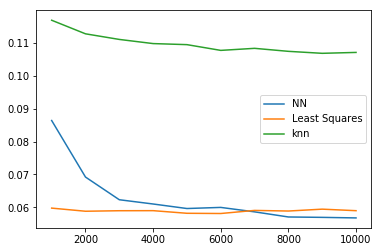

In [188]:
xrange = range(1000, 11000, 1000)

plt.plot(xrange, avg_mabse_20, label='NN')
plt.plot(xrange, avg_lstsq_mabse_20, label='Least Squares')
plt.plot(xrange, knn_avg_mabse_20, label='knn')
plt.legend()
plt.show()

In [162]:
# results_mse_30 = {}
# results_rmse_30 = {}
# results_mabse_30 = {}
# results_lstsq_mse_30 = {}
# results_lstsq_rmse_30 = {}
# results_lstsq_mabse_30 = {}
xrange = range(21000, 41000, 1000)
for x in range(21000, 41000, 1000):
    results_mse_30[x] = []
    results_rmse_30[x] = []
    results_mabse_30[x] = []
    results_lstsq_mse_30[x] = []
    results_lstsq_mabse_30[x] = []
    results_lstsq_rmse_30[x] = []
for trial in range(10):
    print('Trial: {0}'.format(trial))
    nn_rmses = []
    nn_mses = []
    nn_mabses = []

    lstsq_rmses = []
    lstsq_mses = []
    lstsq_mabses = []
    preamble_length = 30
    datasets = generate_data_sets(range(21000, 41000, 1000), preamble_length)
    for i, num_train in zip(range(len(datasets)), xrange):
        print(i)
        dataset = datasets[i]
        preamble_train, preamble_test, channel_train, channel_test = train_test_split(dataset[0], dataset[1], test_size=0.2)
        print(preamble_train.shape, channel_train.shape, preamble_test.shape, channel_test.shape)
        model = create_model(400, 400, preamble_train.shape[1], channel_train.shape[1])
        model.fit(preamble_train, channel_train, verbose=0)
        predictions = model.predict(preamble_test)
        nn_mse = mean_squared_error(predictions, channel_test)
        nn_rmse = np.sqrt(nn_mse)
        nn_mabse = mean_absolute_error(predictions, channel_test)
        nn_mses.append(nn_mse)
        nn_rmses.append(nn_rmse)
        nn_mabses.append(nn_mabse)

        predictions_least_squares = perform_least_squares(preamble_test, preamble_length)
        lstsq_mse = mean_squared_error(predictions_least_squares, channel_test)
        lstsq_rmse = np.sqrt(lstsq_mse)
        lstsq_mabse = mean_absolute_error(predictions_least_squares, channel_test)
        
        results_mse_30[num_train].append(nn_mse)
        results_mabse_30[num_train].append(nn_mabse)
        results_rmse_30[num_train].append(nn_rmse)
        
        results_lstsq_mse_30[num_train].append(lstsq_mse)
        results_lstsq_rmse_30[num_train].append(lstsq_rmse)
        results_lstsq_mabse_30[num_train].append(lstsq_mabse)
        
        lstsq_mses.append(lstsq_mse)
        lstsq_rmses.append(lstsq_rmse)
        lstsq_mabses.append(lstsq_mabse)

    print(nn_mabses)
    print(lstsq_mabses)

print(results_mabse_30)
print(results_lstsq_mabse_30)

Trial: 0
0
(16800, 60) (16800, 2) (4200, 60) (4200, 2)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


1
(17600, 60) (17600, 2) (4400, 60) (4400, 2)
2
(18400, 60) (18400, 2) (4600, 60) (4600, 2)
3
(19200, 60) (19200, 2) (4800, 60) (4800, 2)
4
(20000, 60) (20000, 2) (5000, 60) (5000, 2)
5
(20800, 60) (20800, 2) (5200, 60) (5200, 2)
6
(21600, 60) (21600, 2) (5400, 60) (5400, 2)
7
(22400, 60) (22400, 2) (5600, 60) (5600, 2)
8
(23200, 60) (23200, 2) (5800, 60) (5800, 2)
9
(24000, 60) (24000, 2) (6000, 60) (6000, 2)
10
(24800, 60) (24800, 2) (6200, 60) (6200, 2)
11
(25600, 60) (25600, 2) (6400, 60) (6400, 2)
12
(26400, 60) (26400, 2) (6600, 60) (6600, 2)
13
(27200, 60) (27200, 2) (6800, 60) (6800, 2)
14
(28000, 60) (28000, 2) (7000, 60) (7000, 2)
15
(28800, 60) (28800, 2) (7200, 60) (7200, 2)
16
(29600, 60) (29600, 2) (7400, 60) (7400, 2)
17
(30400, 60) (30400, 2) (7600, 60) (7600, 2)
18
(31200, 60) (31200, 2) (7800, 60) (7800, 2)
19
(32000, 60) (32000, 2) (8000, 60) (8000, 2)
[0.04982811950070453, 0.051596185643421756, 0.05011990893173911, 0.04907863919983228, 0.04998146827118084, 0.0507092

0
(16800, 60) (16800, 2) (4200, 60) (4200, 2)
1
(17600, 60) (17600, 2) (4400, 60) (4400, 2)
2
(18400, 60) (18400, 2) (4600, 60) (4600, 2)
3
(19200, 60) (19200, 2) (4800, 60) (4800, 2)
4
(20000, 60) (20000, 2) (5000, 60) (5000, 2)
5
(20800, 60) (20800, 2) (5200, 60) (5200, 2)
6
(21600, 60) (21600, 2) (5400, 60) (5400, 2)
7
(22400, 60) (22400, 2) (5600, 60) (5600, 2)
8
(23200, 60) (23200, 2) (5800, 60) (5800, 2)
9
(24000, 60) (24000, 2) (6000, 60) (6000, 2)
10
(24800, 60) (24800, 2) (6200, 60) (6200, 2)
11
(25600, 60) (25600, 2) (6400, 60) (6400, 2)
12
(26400, 60) (26400, 2) (6600, 60) (6600, 2)
13
(27200, 60) (27200, 2) (6800, 60) (6800, 2)
14
(28000, 60) (28000, 2) (7000, 60) (7000, 2)
15
(28800, 60) (28800, 2) (7200, 60) (7200, 2)
16
(29600, 60) (29600, 2) (7400, 60) (7400, 2)
17
(30400, 60) (30400, 2) (7600, 60) (7600, 2)
18
(31200, 60) (31200, 2) (7800, 60) (7800, 2)
19
(32000, 60) (32000, 2) (8000, 60) (8000, 2)
[0.05020448108485104, 0.05019356408789828, 0.050503428818116786, 0.048

In [163]:
avg_mabse_30 = []
avg_mse_30 = []
avg_rmse_30 = []

avg_lstsq_mabse_30 = []
avg_lstsq_mse_30 = []
avg_lstsq_rmse_30 = []

for key in range(1000, 41000, 1000):
    avg_mabse_30.append(sum(results_mabse_30[key]) / len(results_mabse_30[key]))
    avg_mse_30.append(sum(results_mse_30[key]) / len(results_mse_30[key]))
    avg_rmse_30.append(sum(results_rmse_30[key]) / len(results_rmse_30[key]))
    
    avg_lstsq_mabse_30.append(sum(results_lstsq_mabse_30[key]) / len(results_lstsq_mabse_30[key]))
    avg_lstsq_mse_30.append(sum(results_lstsq_mse_30[key]) / len(results_lstsq_mse_30[key]))
    avg_lstsq_rmse_30.append(sum(results_lstsq_rmse_30[key]) / len(results_lstsq_rmse_30[key]))
    
print(avg_lstsq_mabse_30)
print(avg_mabse_30)

[0.047492151135392055, 0.046554776042347465, 0.04609875289874894, 0.04666215167921878, 0.046576452225991105, 0.046546301852922016, 0.04684072803438843, 0.04710426444726863, 0.04685426357513026, 0.047063290588936615, 0.046919280848761014, 0.04711090341608466, 0.046697972241235446, 0.04661213954069484, 0.046842788411867495, 0.04675650224061785, 0.04705489863332606, 0.04678261457025069, 0.04685435625423136, 0.046873936130235626, 0.04667360816788123, 0.046995230534976194, 0.046965225874069406, 0.04701662662344322, 0.04679984435676697, 0.0470630326506508, 0.04677139461293454, 0.04688020019791751, 0.04676460782439633, 0.046815183642515946, 0.04675536411901761, 0.047000301757514865, 0.04703898455772972, 0.04681689894950318, 0.04671198285457405, 0.04672905983814152, 0.04670883915936085, 0.0468482382973023, 0.04672758713492817, 0.046691134134590466]
[0.09089530714930771, 0.07311224611601926, 0.0626055594491206, 0.05930004115536995, 0.056498006473143805, 0.05593070729945433, 0.0533232243599374, 

In [193]:
validation_results = {}
for k in range(1, 43, 2):
    validation_results[k] = []
preamble_length = 30
for trial in range(10):
    print('Trial', trial)
    validation_dataset = generate_data_sets(range(10000, 11000, 1000), preamble_length)[0]
    preamble_train, preamble_test, channel_train, channel_test = train_test_split(validation_dataset[0], validation_dataset[1], test_size=0.2)
    for k in range(1, 43, 2):
        print('k', k)
        window_length = preamble_train.shape[1]
        sliding_window_X_train = make_training_set_sliding_window_matrix(preamble_train, window_length)
        predictions = []
        for i in range(preamble_test.shape[0]):           
            prediction= make_prediction_sliding(preamble_test[i], sliding_window_X_train, channel_train, k, window_length)
            predictions.append(prediction)

        mse = mean_squared_error(channel_test, np.array(predictions))
        rmse = np.sqrt(mse)
        mabse = mean_absolute_error(channel_test, np.array(predictions))
        validation_results[k].append(mabse)
for k in validation_results:
    print(k, np.mean(validation_results[k]))

Trial 0
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
k 23
k 25
k 27
k 29
k 31
k 33
k 35
k 37
k 39
k 41
Trial 1
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
k 23
k 25
k 27
k 29
k 31
k 33
k 35
k 37
k 39
k 41
Trial 2
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
k 23
k 25
k 27
k 29
k 31
k 33
k 35
k 37
k 39
k 41
Trial 3
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
k 23
k 25
k 27
k 29
k 31
k 33
k 35
k 37
k 39
k 41
Trial 4
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
k 23
k 25
k 27
k 29
k 31
k 33
k 35
k 37
k 39
k 41
Trial 5
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
k 23
k 25
k 27
k 29
k 31
k 33
k 35
k 37
k 39
k 41
Trial 6
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
k 23
k 25
k 27
k 29
k 31
k 33
k 35
k 37
k 39
k 41
Trial 7
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
k 23
k 25
k 27
k 29
k 31
k 33
k 35
k 37
k 39
k 41
Trial 8
k 1
k 3
k 5
k 7
k 9
k 11
k 13
k 15
k 17
k 19
k 21
k 23
k 25
k 27
k 29
k 31
k 33
k 35
k 37
k 39
k 41
Trial 9
k 1
k 3
k 5
k 7
k 9


In [194]:
knn_results_mse_30 = {}
knn_results_rmse_30 = {}
knn_results_mabse_30 = {}
xrange = range(1000, 41000, 1000)
for x in range(1000, 41000, 1000):
    knn_results_mse_30[x] = []
    knn_results_rmse_30[x] = []
    knn_results_mabse_30[x] = []
for trial in range(10):
    preamble_length = 30
    knn_rmses = []
    knn_mses = []
    knn_mabses = []
    datasets = generate_data_sets(range(1000, 41000, 1000), preamble_length)
    for i, num_train in zip(range(len(datasets)), xrange):
        print(i)
        dataset = datasets[i]
        preamble_train, preamble_test, channel_train, channel_test = train_test_split(dataset[0], dataset[1], test_size=0.2)
        print(preamble_train.shape, channel_train.shape, preamble_test.shape, channel_test.shape)
        window_length = preamble_train.shape[1]
        k = 11
        sliding_window_X_train = make_training_set_sliding_window_matrix(preamble_train, window_length)
        predictions = []
        for i in range(preamble_test.shape[0]):           
            prediction= make_prediction_sliding(preamble_test[i], sliding_window_X_train, channel_train, k, window_length)
            predictions.append(prediction)

        mse = mean_squared_error(channel_test, np.array(predictions))
        rmse = np.sqrt(mse)
        mabse = mean_absolute_error(channel_test, np.array(predictions))
        knn_mses.append(mse)
        knn_rmses.append(rmse)
        knn_mabses.append(mabse)
        knn_results_mse_30[num_train].append(mse)
        knn_results_mabse_30[num_train].append(mabse)
        knn_results_rmse_30[num_train].append(rmse)
    print(knn_mabses)
print(knn_results_mabse_30)



0
(800, 60) (800, 2) (200, 60) (200, 2)
1
(1600, 60) (1600, 2) (400, 60) (400, 2)
2
(2400, 60) (2400, 2) (600, 60) (600, 2)
3
(3200, 60) (3200, 2) (800, 60) (800, 2)
4
(4000, 60) (4000, 2) (1000, 60) (1000, 2)
5
(4800, 60) (4800, 2) (1200, 60) (1200, 2)
6
(5600, 60) (5600, 2) (1400, 60) (1400, 2)
7
(6400, 60) (6400, 2) (1600, 60) (1600, 2)
8
(7200, 60) (7200, 2) (1800, 60) (1800, 2)
9
(8000, 60) (8000, 2) (2000, 60) (2000, 2)
10
(8800, 60) (8800, 2) (2200, 60) (2200, 2)
11
(9600, 60) (9600, 2) (2400, 60) (2400, 2)
12
(10400, 60) (10400, 2) (2600, 60) (2600, 2)
13
(11200, 60) (11200, 2) (2800, 60) (2800, 2)
14
(12000, 60) (12000, 2) (3000, 60) (3000, 2)
15
(12800, 60) (12800, 2) (3200, 60) (3200, 2)
16
(13600, 60) (13600, 2) (3400, 60) (3400, 2)
17
(14400, 60) (14400, 2) (3600, 60) (3600, 2)
18
(15200, 60) (15200, 2) (3800, 60) (3800, 2)
19
(16000, 60) (16000, 2) (4000, 60) (4000, 2)
20
(16800, 60) (16800, 2) (4200, 60) (4200, 2)
21
(17600, 60) (17600, 2) (4400, 60) (4400, 2)
22
(18400,

5
(4800, 60) (4800, 2) (1200, 60) (1200, 2)
6
(5600, 60) (5600, 2) (1400, 60) (1400, 2)
7
(6400, 60) (6400, 2) (1600, 60) (1600, 2)
8
(7200, 60) (7200, 2) (1800, 60) (1800, 2)
9
(8000, 60) (8000, 2) (2000, 60) (2000, 2)
10
(8800, 60) (8800, 2) (2200, 60) (2200, 2)
11
(9600, 60) (9600, 2) (2400, 60) (2400, 2)
12
(10400, 60) (10400, 2) (2600, 60) (2600, 2)
13
(11200, 60) (11200, 2) (2800, 60) (2800, 2)
14
(12000, 60) (12000, 2) (3000, 60) (3000, 2)
15
(12800, 60) (12800, 2) (3200, 60) (3200, 2)
16
(13600, 60) (13600, 2) (3400, 60) (3400, 2)
17
(14400, 60) (14400, 2) (3600, 60) (3600, 2)
18
(15200, 60) (15200, 2) (3800, 60) (3800, 2)
19
(16000, 60) (16000, 2) (4000, 60) (4000, 2)
20
(16800, 60) (16800, 2) (4200, 60) (4200, 2)
21
(17600, 60) (17600, 2) (4400, 60) (4400, 2)
22
(18400, 60) (18400, 2) (4600, 60) (4600, 2)
23
(19200, 60) (19200, 2) (4800, 60) (4800, 2)
24
(20000, 60) (20000, 2) (5000, 60) (5000, 2)
25
(20800, 60) (20800, 2) (5200, 60) (5200, 2)
26
(21600, 60) (21600, 2) (5400,

10
(8800, 60) (8800, 2) (2200, 60) (2200, 2)
11
(9600, 60) (9600, 2) (2400, 60) (2400, 2)
12
(10400, 60) (10400, 2) (2600, 60) (2600, 2)
13
(11200, 60) (11200, 2) (2800, 60) (2800, 2)
14
(12000, 60) (12000, 2) (3000, 60) (3000, 2)
15
(12800, 60) (12800, 2) (3200, 60) (3200, 2)
16
(13600, 60) (13600, 2) (3400, 60) (3400, 2)
17
(14400, 60) (14400, 2) (3600, 60) (3600, 2)
18
(15200, 60) (15200, 2) (3800, 60) (3800, 2)
19
(16000, 60) (16000, 2) (4000, 60) (4000, 2)
20
(16800, 60) (16800, 2) (4200, 60) (4200, 2)
21
(17600, 60) (17600, 2) (4400, 60) (4400, 2)
22
(18400, 60) (18400, 2) (4600, 60) (4600, 2)
23
(19200, 60) (19200, 2) (4800, 60) (4800, 2)
24
(20000, 60) (20000, 2) (5000, 60) (5000, 2)
25
(20800, 60) (20800, 2) (5200, 60) (5200, 2)
26
(21600, 60) (21600, 2) (5400, 60) (5400, 2)
27
(22400, 60) (22400, 2) (5600, 60) (5600, 2)
28
(23200, 60) (23200, 2) (5800, 60) (5800, 2)
29
(24000, 60) (24000, 2) (6000, 60) (6000, 2)
30
(24800, 60) (24800, 2) (6200, 60) (6200, 2)
31
(25600, 60) (2

14
(12000, 60) (12000, 2) (3000, 60) (3000, 2)
15
(12800, 60) (12800, 2) (3200, 60) (3200, 2)
16
(13600, 60) (13600, 2) (3400, 60) (3400, 2)
17
(14400, 60) (14400, 2) (3600, 60) (3600, 2)
18
(15200, 60) (15200, 2) (3800, 60) (3800, 2)
19
(16000, 60) (16000, 2) (4000, 60) (4000, 2)
20
(16800, 60) (16800, 2) (4200, 60) (4200, 2)
21
(17600, 60) (17600, 2) (4400, 60) (4400, 2)
22
(18400, 60) (18400, 2) (4600, 60) (4600, 2)
23
(19200, 60) (19200, 2) (4800, 60) (4800, 2)
24
(20000, 60) (20000, 2) (5000, 60) (5000, 2)
25
(20800, 60) (20800, 2) (5200, 60) (5200, 2)
26
(21600, 60) (21600, 2) (5400, 60) (5400, 2)
27
(22400, 60) (22400, 2) (5600, 60) (5600, 2)
28
(23200, 60) (23200, 2) (5800, 60) (5800, 2)
29
(24000, 60) (24000, 2) (6000, 60) (6000, 2)
30
(24800, 60) (24800, 2) (6200, 60) (6200, 2)
31
(25600, 60) (25600, 2) (6400, 60) (6400, 2)
32
(26400, 60) (26400, 2) (6600, 60) (6600, 2)
33
(27200, 60) (27200, 2) (6800, 60) (6800, 2)
34
(28000, 60) (28000, 2) (7000, 60) (7000, 2)
35
(28800, 60

In [197]:
knn_avg_mabse_30 = []
knn_avg_mse_30 = []
knn_avg_rmse_30 = []
for key in range(1000, 41000, 1000):
    knn_avg_mabse_30.append(sum(knn_results_mabse_30[key]) / len(knn_results_mabse_30[key]))
    knn_avg_mse_30.append(sum(knn_results_mse_30[key]) / len(knn_results_mse_30[key]))
    knn_avg_rmse_30.append(sum(knn_results_rmse_30[key]) / len(knn_results_rmse_30[key]))
    
print(knn_avg_mabse_30)

[0.11672059475507664, 0.11411427930227347, 0.11285197329325077, 0.11098987906680058, 0.11032235031935919, 0.11043970881611323, 0.10918174387582993, 0.10897995545157235, 0.10767702500275633, 0.10790592930401866, 0.1076575922329351, 0.10777454955171395, 0.10697067771291788, 0.10624927735376961, 0.1065518287217749, 0.10594043903903536, 0.1055649605243864, 0.1060362179418044, 0.10581695547664494, 0.10549641621909042, 0.10536953512166605, 0.10500140774413091, 0.1050204988185948, 0.10485707292411191, 0.10407087562418833, 0.1045331521635747, 0.10457493216749165, 0.10458268458489914, 0.10463312758271334, 0.10390045621501265, 0.10421913609122195, 0.10425769378081358, 0.10335347754915017, 0.10372896573832557, 0.10315128782811556, 0.10361306962005527, 0.10352919911583074, 0.1031533192734285, 0.10308893100833964, 0.10302604904478711]


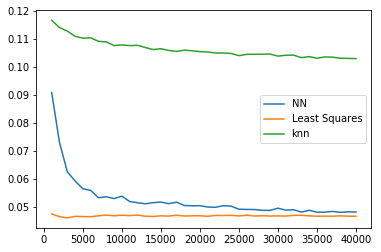

In [198]:
xrange = range(1000, 41000, 1000)
plt.plot(xrange, avg_mabse_30, label='NN')
plt.plot(xrange, avg_lstsq_mabse_30, label='Least Squares')
plt.plot(xrange, knn_avg_mabse_30, label='knn')
plt.legend()
plt.show()

In [165]:
results_mse_40 = {}
results_rmse_40 = {}
results_mabse_40 = {}
results_lstsq_mse_40 = {}
results_lstsq_rmse_40 = {}
results_lstsq_mabse_40 = {}
xrange = range(1000, 41000, 1000)
for x in range(1000, 41000, 1000):
    results_mse_40[x] = []
    results_rmse_40[x] = []
    results_mabse_40[x] = []
    results_lstsq_mse_40[x] = []
    results_lstsq_mabse_40[x] = []
    results_lstsq_rmse_40[x] = []
for trial in range(10):
    print('Trial: {0}'.format(trial))
    nn_rmses = []
    nn_mses = []
    nn_mabses = []

    lstsq_rmses = []
    lstsq_mses = []
    lstsq_mabses = []
    preamble_length = 40
    datasets = generate_data_sets(range(1000, 41000, 1000), preamble_length)
    for i, num_train in zip(range(len(datasets)), xrange):
        print(i)
        dataset = datasets[i]
        preamble_train, preamble_test, channel_train, channel_test = train_test_split(dataset[0], dataset[1], test_size=0.2)
        print(preamble_train.shape, channel_train.shape, preamble_test.shape, channel_test.shape)
        model = create_model(500, 500, preamble_train.shape[1], channel_train.shape[1])
        model.fit(preamble_train, channel_train, verbose=0)
        predictions = model.predict(preamble_test)
        nn_mse = mean_squared_error(predictions, channel_test)
        nn_rmse = np.sqrt(nn_mse)
        nn_mabse = mean_absolute_error(predictions, channel_test)
        nn_mses.append(nn_mse)
        nn_rmses.append(nn_rmse)
        nn_mabses.append(nn_mabse)

        predictions_least_squares = perform_least_squares(preamble_test, preamble_length)
        lstsq_mse = mean_squared_error(predictions_least_squares, channel_test)
        lstsq_rmse = np.sqrt(lstsq_mse)
        lstsq_mabse = mean_absolute_error(predictions_least_squares, channel_test)
        
        results_mse_40[num_train].append(nn_mse)
        results_mabse_40[num_train].append(nn_mabse)
        results_rmse_40[num_train].append(nn_rmse)
        
        results_lstsq_mse_40[num_train].append(lstsq_mse)
        results_lstsq_rmse_40[num_train].append(lstsq_rmse)
        results_lstsq_mabse_40[num_train].append(lstsq_mabse)
        
        lstsq_mses.append(lstsq_mse)
        lstsq_rmses.append(lstsq_rmse)
        lstsq_mabses.append(lstsq_mabse)

    print(nn_mabses)
    print(lstsq_mabses)

print(results_mabse_40)
print(results_lstsq_mabse_40)

Trial: 0
0
(800, 80) (800, 2) (200, 80) (200, 2)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


1
(1600, 80) (1600, 2) (400, 80) (400, 2)
2
(2400, 80) (2400, 2) (600, 80) (600, 2)
3
(3200, 80) (3200, 2) (800, 80) (800, 2)
4
(4000, 80) (4000, 2) (1000, 80) (1000, 2)
5
(4800, 80) (4800, 2) (1200, 80) (1200, 2)
6
(5600, 80) (5600, 2) (1400, 80) (1400, 2)
7
(6400, 80) (6400, 2) (1600, 80) (1600, 2)
8
(7200, 80) (7200, 2) (1800, 80) (1800, 2)
9
(8000, 80) (8000, 2) (2000, 80) (2000, 2)
10
(8800, 80) (8800, 2) (2200, 80) (2200, 2)
11
(9600, 80) (9600, 2) (2400, 80) (2400, 2)
12
(10400, 80) (10400, 2) (2600, 80) (2600, 2)
13
(11200, 80) (11200, 2) (2800, 80) (2800, 2)
14
(12000, 80) (12000, 2) (3000, 80) (3000, 2)
15
(12800, 80) (12800, 2) (3200, 80) (3200, 2)
16
(13600, 80) (13600, 2) (3400, 80) (3400, 2)
17
(14400, 80) (14400, 2) (3600, 80) (3600, 2)
18
(15200, 80) (15200, 2) (3800, 80) (3800, 2)
19
(16000, 80) (16000, 2) (4000, 80) (4000, 2)
20
(16800, 80) (16800, 2) (4200, 80) (4200, 2)
21
(17600, 80) (17600, 2) (4400, 80) (4400, 2)
22
(18400, 80) (18400, 2) (4600, 80) (4600, 2)
23


26
(21600, 80) (21600, 2) (5400, 80) (5400, 2)
27
(22400, 80) (22400, 2) (5600, 80) (5600, 2)
28
(23200, 80) (23200, 2) (5800, 80) (5800, 2)
29
(24000, 80) (24000, 2) (6000, 80) (6000, 2)
30
(24800, 80) (24800, 2) (6200, 80) (6200, 2)
31
(25600, 80) (25600, 2) (6400, 80) (6400, 2)
32
(26400, 80) (26400, 2) (6600, 80) (6600, 2)
33
(27200, 80) (27200, 2) (6800, 80) (6800, 2)
34
(28000, 80) (28000, 2) (7000, 80) (7000, 2)
35
(28800, 80) (28800, 2) (7200, 80) (7200, 2)
36
(29600, 80) (29600, 2) (7400, 80) (7400, 2)
37
(30400, 80) (30400, 2) (7600, 80) (7600, 2)
38
(31200, 80) (31200, 2) (7800, 80) (7800, 2)
39
(32000, 80) (32000, 2) (8000, 80) (8000, 2)
[0.10299816930188163, 0.08058499485710478, 0.06865775801065242, 0.06214091658158544, 0.060181232510421095, 0.05221237136581356, 0.05198426558847901, 0.050669257466932155, 0.050647582825639095, 0.050924349421823285, 0.047268151071296546, 0.04998481278484576, 0.049358453901914734, 0.04797001250148776, 0.04783375051813949, 0.049033127609189396

0
(800, 80) (800, 2) (200, 80) (200, 2)
1
(1600, 80) (1600, 2) (400, 80) (400, 2)
2
(2400, 80) (2400, 2) (600, 80) (600, 2)
3
(3200, 80) (3200, 2) (800, 80) (800, 2)
4
(4000, 80) (4000, 2) (1000, 80) (1000, 2)
5
(4800, 80) (4800, 2) (1200, 80) (1200, 2)
6
(5600, 80) (5600, 2) (1400, 80) (1400, 2)
7
(6400, 80) (6400, 2) (1600, 80) (1600, 2)
8
(7200, 80) (7200, 2) (1800, 80) (1800, 2)
9
(8000, 80) (8000, 2) (2000, 80) (2000, 2)
10
(8800, 80) (8800, 2) (2200, 80) (2200, 2)
11
(9600, 80) (9600, 2) (2400, 80) (2400, 2)
12
(10400, 80) (10400, 2) (2600, 80) (2600, 2)
13
(11200, 80) (11200, 2) (2800, 80) (2800, 2)
14
(12000, 80) (12000, 2) (3000, 80) (3000, 2)
15
(12800, 80) (12800, 2) (3200, 80) (3200, 2)
16
(13600, 80) (13600, 2) (3400, 80) (3400, 2)
17
(14400, 80) (14400, 2) (3600, 80) (3600, 2)
18
(15200, 80) (15200, 2) (3800, 80) (3800, 2)
19
(16000, 80) (16000, 2) (4000, 80) (4000, 2)
20
(16800, 80) (16800, 2) (4200, 80) (4200, 2)
21
(17600, 80) (17600, 2) (4400, 80) (4400, 2)
22
(18400,

25
(20800, 80) (20800, 2) (5200, 80) (5200, 2)
26
(21600, 80) (21600, 2) (5400, 80) (5400, 2)
27
(22400, 80) (22400, 2) (5600, 80) (5600, 2)
28
(23200, 80) (23200, 2) (5800, 80) (5800, 2)
29
(24000, 80) (24000, 2) (6000, 80) (6000, 2)
30
(24800, 80) (24800, 2) (6200, 80) (6200, 2)
31
(25600, 80) (25600, 2) (6400, 80) (6400, 2)
32
(26400, 80) (26400, 2) (6600, 80) (6600, 2)
33
(27200, 80) (27200, 2) (6800, 80) (6800, 2)
34
(28000, 80) (28000, 2) (7000, 80) (7000, 2)
35
(28800, 80) (28800, 2) (7200, 80) (7200, 2)
36
(29600, 80) (29600, 2) (7400, 80) (7400, 2)
37
(30400, 80) (30400, 2) (7600, 80) (7600, 2)
38
(31200, 80) (31200, 2) (7800, 80) (7800, 2)
39
(32000, 80) (32000, 2) (8000, 80) (8000, 2)
[0.10351296896937967, 0.07934162882406665, 0.06601931834508332, 0.0592680511520818, 0.060126574376030584, 0.05910836791961774, 0.05473605030133616, 0.049828494121104655, 0.05167073074917218, 0.05001593819025032, 0.04914345521808748, 0.050567756762479155, 0.0507476012714458, 0.048712301698951035

In [166]:
avg_mabse_40 = []
avg_mse_40 = []
avg_rmse_40 = []

avg_lstsq_mabse_40 = []
avg_lstsq_mse_40 = []
avg_lstsq_rmse_40 = []

for key in range(1000, 41000, 1000):
    avg_mabse_40.append(sum(results_mabse_40[key]) / len(results_mabse_40[key]))
    avg_mse_40.append(sum(results_mse_40[key]) / len(results_mse_40[key]))
    avg_rmse_40.append(sum(results_rmse_40[key]) / len(results_rmse_40[key]))
    
    avg_lstsq_mabse_40.append(sum(results_lstsq_mabse_40[key]) / len(results_lstsq_mabse_40[key]))
    avg_lstsq_mse_40.append(sum(results_lstsq_mse_40[key]) / len(results_lstsq_mse_40[key]))
    avg_lstsq_rmse_40.append(sum(results_lstsq_rmse_40[key]) / len(results_lstsq_rmse_40[key]))
    
print(avg_lstsq_mabse_40)
print(avg_mabse_40)

[0.040557448941600314, 0.03974322189034024, 0.040266719731871105, 0.03995731343202513, 0.039791301787444465, 0.04007919301614703, 0.039822510218411364, 0.039619019762316465, 0.040053583308470406, 0.040011844880213664, 0.04014336916059546, 0.03991436580080597, 0.03995937448651024, 0.03984792647223938, 0.04005805461951796, 0.0400030545455765, 0.039896274835303905, 0.04017992197440267, 0.040133083931414085, 0.04003389875060413, 0.04012698254171928, 0.04001253552670573, 0.04000013163606751, 0.040035556022727674, 0.040133073404063926, 0.040068790852792115, 0.04010462204647114, 0.040078138536327954, 0.04005308195143185, 0.04001064470745273, 0.039851076968629676, 0.04008591841432133, 0.04006329346621753, 0.04003469728259228, 0.04001109236240164, 0.040011491602288465, 0.040001589679717474, 0.03986836178553293, 0.03996168959637894, 0.039977297500486904]
[0.09849867891853435, 0.07906142554195798, 0.06808960351180122, 0.061066895028096736, 0.057571530057634546, 0.05540605953532009, 0.053671536880

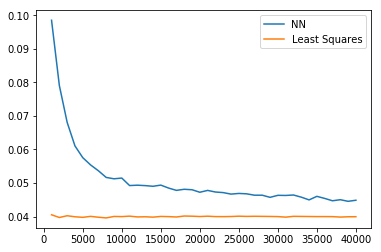

In [167]:
xrange = range(1000, 41000, 1000)
plt.plot(xrange, avg_mabse_40, label='NN')
plt.plot(xrange, avg_lstsq_mabse_40, label='Least Squares')
plt.legend()
plt.show()

In [168]:
results_mse_50 = {}
results_rmse_50 = {}
results_mabse_50 = {}
results_lstsq_mse_50 = {}
results_lstsq_rmse_50 = {}
results_lstsq_mabse_50 = {}
xrange = range(10000,111000, 10000)
for x in range(10000, 111000, 10000):
    results_mse_50[x] = []
    results_rmse_50[x] = []
    results_mabse_50[x] = []
    results_lstsq_mse_50[x] = []
    results_lstsq_mabse_50[x] = []
    results_lstsq_rmse_50[x] = []
for trial in range(10):
    print('Trial: {0}'.format(trial))
    nn_rmses = []
    nn_mses = []
    nn_mabses = []

    lstsq_rmses = []
    lstsq_mses = []
    lstsq_mabses = []
    preamble_length = 50
    datasets = generate_data_sets(range(10000, 111000, 10000), preamble_length)
    for i, num_train in zip(range(len(datasets)), xrange):
        print(i)
        dataset = datasets[i]
        preamble_train, preamble_test, channel_train, channel_test = train_test_split(dataset[0], dataset[1], test_size=0.2)
        print(preamble_train.shape, channel_train.shape, preamble_test.shape, channel_test.shape)
        model = create_model(600, 600, preamble_train.shape[1], channel_train.shape[1])
        model.fit(preamble_train, channel_train, verbose=0)
        predictions = model.predict(preamble_test)
        nn_mse = mean_squared_error(predictions, channel_test)
        nn_rmse = np.sqrt(nn_mse)
        nn_mabse = mean_absolute_error(predictions, channel_test)
        nn_mses.append(nn_mse)
        nn_rmses.append(nn_rmse)
        nn_mabses.append(nn_mabse)

        predictions_least_squares = perform_least_squares(preamble_test, preamble_length)
        lstsq_mse = mean_squared_error(predictions_least_squares, channel_test)
        lstsq_rmse = np.sqrt(lstsq_mse)
        lstsq_mabse = mean_absolute_error(predictions_least_squares, channel_test)
        
        results_mse_50[num_train].append(nn_mse)
        results_mabse_50[num_train].append(nn_mabse)
        results_rmse_50[num_train].append(nn_rmse)
        
        results_lstsq_mse_50[num_train].append(lstsq_mse)
        results_lstsq_rmse_50[num_train].append(lstsq_rmse)
        results_lstsq_mabse_50[num_train].append(lstsq_mabse)
        
        lstsq_mses.append(lstsq_mse)
        lstsq_rmses.append(lstsq_rmse)
        lstsq_mabses.append(lstsq_mabse)

    print(nn_mabses)
    print(lstsq_mabses)

print(results_mabse_50)
print(results_lstsq_mabse_50)

Trial: 0
0
(8000, 100) (8000, 2) (2000, 100) (2000, 2)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


1
(16000, 100) (16000, 2) (4000, 100) (4000, 2)
2
(24000, 100) (24000, 2) (6000, 100) (6000, 2)
3
(32000, 100) (32000, 2) (8000, 100) (8000, 2)
4
(40000, 100) (40000, 2) (10000, 100) (10000, 2)
5
(48000, 100) (48000, 2) (12000, 100) (12000, 2)
6
(56000, 100) (56000, 2) (14000, 100) (14000, 2)
7
(64000, 100) (64000, 2) (16000, 100) (16000, 2)
8
(72000, 100) (72000, 2) (18000, 100) (18000, 2)
9
(80000, 100) (80000, 2) (20000, 100) (20000, 2)
10
(88000, 100) (88000, 2) (22000, 100) (22000, 2)
[0.05479173808872419, 0.04474458657059373, 0.04387793412982073, 0.04174998775645106, 0.04139889069449326, 0.03997972182647453, 0.0421898531680581, 0.03952279642887592, 0.03955207104684867, 0.039089525161054475, 0.038596424908826775]
[0.03507876856329565, 0.03473897497473471, 0.03589839204385996, 0.03562250349640614, 0.03563411948136122, 0.03511069931347903, 0.03558190844474951, 0.03536528046310107, 0.03537413987320304, 0.03561738118206682, 0.03524789477457403]
Trial: 1
0
(8000, 100) (8000, 2) (2000, 

2
(24000, 100) (24000, 2) (6000, 100) (6000, 2)
3
(32000, 100) (32000, 2) (8000, 100) (8000, 2)
4
(40000, 100) (40000, 2) (10000, 100) (10000, 2)
5
(48000, 100) (48000, 2) (12000, 100) (12000, 2)
6
(56000, 100) (56000, 2) (14000, 100) (14000, 2)
7
(64000, 100) (64000, 2) (16000, 100) (16000, 2)
8
(72000, 100) (72000, 2) (18000, 100) (18000, 2)
9
(80000, 100) (80000, 2) (20000, 100) (20000, 2)
10
(88000, 100) (88000, 2) (22000, 100) (22000, 2)
[0.05004340096713505, 0.04419051269210619, 0.04380018627574363, 0.042381335626958935, 0.04165270120654735, 0.04064149800128446, 0.03917653452729873, 0.04169303699466847, 0.038678768876974814, 0.03770176556434554, 0.038735603233377616]
[0.035450274945628524, 0.03479943071060139, 0.0354129974688552, 0.03544110270603956, 0.03568649528432517, 0.03556453281954072, 0.03538612884410354, 0.035270340349677465, 0.03553607034860461, 0.035490818222405005, 0.03569050069746639]
Trial: 9
0
(8000, 100) (8000, 2) (2000, 100) (2000, 2)
1
(16000, 100) (16000, 2) (40

In [169]:
avg_mabse_50 = []
avg_mse_50 = []
avg_rmse_50 = []

avg_lstsq_mabse_50 = []
avg_lstsq_mse_50 = []
avg_lstsq_rmse_50 = []

for key in range(10000, 111000, 10000):
    avg_mabse_50.append(sum(results_mabse_50[key]) / len(results_mabse_50[key]))
    avg_mse_50.append(sum(results_mse_50[key]) / len(results_mse_50[key]))
    avg_rmse_50.append(sum(results_rmse_50[key]) / len(results_rmse_50[key]))
    
    avg_lstsq_mabse_50.append(sum(results_lstsq_mabse_50[key]) / len(results_lstsq_mabse_50[key]))
    avg_lstsq_mse_50.append(sum(results_lstsq_mse_50[key]) / len(results_lstsq_mse_50[key]))
    avg_lstsq_rmse_50.append(sum(results_lstsq_rmse_50[key]) / len(results_lstsq_rmse_50[key]))
    
print(avg_lstsq_mabse_50)
print(avg_mabse_50)

[0.035457062157031635, 0.03517021140228131, 0.035422762214127726, 0.03548651959881878, 0.03549560945215851, 0.03537715305133303, 0.03542558374473141, 0.03547893759854736, 0.03537666606310981, 0.03546342144949749, 0.03547133243495133]
[0.050724603769372954, 0.04547324987582701, 0.04439826822502972, 0.04270549102448329, 0.04152311978224139, 0.041195769205946677, 0.04036391799446986, 0.04049102227212093, 0.03920722050953053, 0.03879957541171945, 0.03884739701293768]


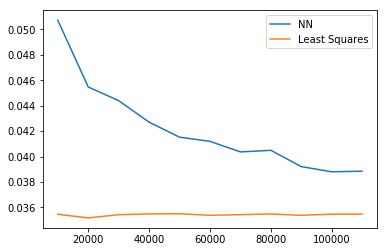

In [170]:
xrange = range(10000, 111000, 10000)
plt.plot(xrange, avg_mabse_50, label='NN')
plt.plot(xrange, avg_lstsq_mabse_50, label='Least Squares')
plt.legend()
plt.show()

In [154]:
train_size_100000 = generate_data_sets(range(125000, 200000, 100000), 30)
dataset = train_size_100000[0]
preamble_train, preamble_test, channel_train, channel_test = train_test_split(dataset[0], dataset[1], test_size=0.2)
print(preamble_train.shape, preamble_test.shape, channel_train.shape, channel_test.shape)
model = create_model(300, 300, preamble_train.shape[1], channel_train.shape[1])
model.fit(preamble_train, channel_train, epochs=10)
predictions = model.predict(preamble_test)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(predictions, channel_test)
mabse = mean_absolute_error(predictions, channel_test)
print('Mean Squared Error: {0}'.format(mse))
print('Mean Absolute Error: {0}'.format(mabse))



(100000, 60) (25000, 60) (100000, 2) (25000, 2)
Epoch 1/10
100000/100000 [==============================] - 19s - loss: 0.0058 - mean_absolute_error: 0.0583    
Epoch 2/10
100000/100000 [==============================] - 16s - loss: 0.0035 - mean_absolute_error: 0.0469    
Epoch 3/10
100000/100000 [==============================] - 16s - loss: 0.0032 - mean_absolute_error: 0.0450    
Epoch 4/10
100000/100000 [==============================] - 16s - loss: 0.0031 - mean_absolute_error: 0.0439    
Epoch 5/10
100000/100000 [==============================] - 16s - loss: 0.0029 - mean_absolute_error: 0.0429    
Epoch 6/10
100000/100000 [==============================] - 16s - loss: 0.0028 - mean_absolute_error: 0.0420    
Epoch 7/10
100000/100000 [==============================] - 16s - loss: 0.0028 - mean_absolute_error: 0.0414    
Epoch 8/10
100000/100000 [==============================] - 16s - loss: 0.0026 - mean_absolute_error: 0.0405    
Epoch 9/10
100000/100000 [======================

In [155]:
print(preamble_test.shape)
predictions_least_squares = perform_least_squares(preamble_test, 30)
mse = mean_squared_error(predictions_least_squares, channel_test)
mabse = mean_absolute_error(predictions_least_squares, channel_test)
print(predictions_least_squares)
print(channel_test)
print('Mean Squared Error: {0}'.format(mse))
print('Mean Absolute Error: {0}'.format(mabse))

(25000, 60)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


[[0.20476917 0.51756619]
 [0.50826993 0.2335274 ]
 [0.5034509  0.42116592]
 ...
 [0.66920661 0.35886682]
 [0.41707553 0.50426178]
 [0.43724255 0.49974544]]
[[0.22211307 0.49851956]
 [0.50381746 0.22388906]
 [0.54407582 0.45592418]
 ...
 [0.61350763 0.38649237]
 [0.44258616 0.55741384]
 [0.35849086 0.64150914]]
Mean Squared Error: 0.0035611810402878
Mean Absolute Error: 0.04679914396537707


In [138]:
np.argmax(predictions_least_squares, axis = 0)
predictions_least_squares[778]

array([0.41080796, 0.511018  ])

In [114]:
channel_test[778]

array([0.56184622, 0.24178541])

In [107]:
mean_absolute_error(predictions_least_squares, channel_test)

390051508878.56006

In [120]:
print(preamble_test.shape)
matrix = generate_topleitz(preamble_test[778][:5])
U, S, V = np.linalg.svd(matrix)
print(matrix)
# np.linalg.lstsq(matrix, preamble_test[778][100:])

(2000, 20)
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
